In [1]:
import gym
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque
from termcolor import colored
from gym import wrappers
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
env = gym.make('CartPole-v0')
# env = wrappers.Monitor(env,'./monitor')

[2017-09-26 11:00:11,720] Making new env: CartPole-v0


In [3]:
print(env.observation_space.shape)
print(env.action_space.n)

(4,)
2


In [4]:
s = env.reset()
for i in range(500):
    env.render()
    new_s, r, done, _ = env.step(env.action_space.sample())
    if done:
        break
env.close()

In [4]:
class Agent():
    def __init__(self, epsilon, gamma, lr, batchsize, memory, epsilon_decay):
        self.epsilon = epsilon
        self.epsilon_min = 0.01
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.lr = lr
        self.batchsize = batchsize
        self.memory = deque(maxlen=memory)
        self.model = self.create_model()
        self.model_target = self.create_model()
        
    def create_model(self):
        model = Sequential()
        model.add(Dense(32, input_dim=4, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(env.action_space.n, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(self.lr))
        return model
    
    def update_target(self):
        self.model_target.set_weights(self.model.get_weights())
    
    def getAction(self, state):
        # if self.epsilon >= self.epsilon_min:
        if self.epsilon >= np.random.rand():
            return int(np.random.randint(low=0, high=2, size=1))
        else:
            return np.argmax(self.model.predict(state.reshape(1, 4)))
    
    def getPolicy(self, state):
        return np.argmax(self.model.predict(state.reshape(1, 4)))
    
    def getValueTarget(self, state, action):
        qs = self.model_target.predict(state.reshape(1,4))[0]
        return qs[action]
    
    def remember(self, experience):
        self.memory.append(experience)
        
    def train(self):
        index = np.random.choice(len(self.memory), self.batchsize)
        minibatch = [self.memory[i] for i in index]
        # q_fit = []
        # states = []
        for state, action, reward, next_state, done in minibatch:
            q_current = self.model.predict(state.reshape(1,4))
            if done:
                q_target = reward
            else:
                q_target = reward + self.gamma * self.getValueTarget(next_state.reshape(1,4),self.getPolicy(next_state.reshape(1, 4)))
            # print(q_current.shape)
            q_current[0][action] = q_target
            # q_fit.append(q_current)
            # states.append(state)
            self.model.fit(x = state.reshape(1, 4), y = q_current, epochs=1, verbose = 0)
        # q_fit = np.reshape(q_fit,(-1,2))
        # states = np.array(states)
        # self.model.fit(x = states, y = q_fit, epochs=1, verbose = 0)
        if self.epsilon > self.epsilon_min:
            self.epsilon = self.epsilon*self.epsilon_decay

In [10]:
agent = Agent(1, 0.99, 0.01, 64, 5000, 0.999)

In [11]:
episodes = 2000
t_max = 1000
refresh_target = 50

rewards_list = []

for episode in range(episodes):
    total_reward = 0
    s = env.reset()
    for t in range(t_max):
        a = agent.getAction(s)
        next_s, r, done, _ = env.step(a)
        agent.remember([s,a,r,next_s,done])
        total_reward = total_reward + r
        s = next_s
        if done:
            break
    agent.train()
    rewards_list.append(total_reward)
    if total_reward<150:
        print(colored('episode:{0}, total_reward:{1}, epsilon:{2}'.format(episode+1, total_reward, agent.epsilon),'red'))
    else:
        print(colored('episode:{0}, total_reward:{1}, epsilon:{2}'.format(episode+1, total_reward, agent.epsilon),'green'))
    if episode%refresh_target==0:
        agent.update_target()

episode:1, total_reward:12.0, epsilon:0.999
episode:2, total_reward:14.0, epsilon:0.998001
episode:3, total_reward:16.0, epsilon:0.997002999
episode:4, total_reward:33.0, epsilon:0.996005996001
episode:5, total_reward:12.0, epsilon:0.995009990004999
episode:6, total_reward:12.0, epsilon:0.994014980014994
episode:7, total_reward:25.0, epsilon:0.993020965034979
episode:8, total_reward:16.0, epsilon:0.9920279440699441
episode:9, total_reward:12.0, epsilon:0.9910359161258742
episode:10, total_reward:18.0, epsilon:0.9900448802097482
episode:11, total_reward:13.0, epsilon:0.9890548353295385
episode:12, total_reward:22.0, epsilon:0.988065780494209
episode:13, total_reward:16.0, epsilon:0.9870777147137147
episode:14, total_reward:27.0, epsilon:0.986090636999001
episode:15, total_reward:16.0, epsilon:0.9851045463620021
episode:16, total_reward:14.0, epsilon:0.98411944181564
episode:17, total_reward:9.0, epsilon:0.9831353223738244
episode:18, total_reward:18.0, epsilon:0.9821521870514506
episode

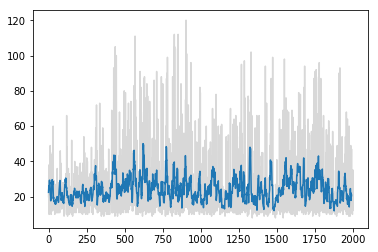

In [9]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

smoothed_rews = running_mean(rewards_list, 10)
plt.plot(rewards_list, color='grey', alpha=0.3)
plt.plot(smoothed_rews)

In [ ]:
env.close()
gym.upload('./monitor', api_key='')

In [39]:
s = env.reset()
total_reward = 0
for i in range(1000):
    env.render()
    new_s, r, done, _ = env.step(np.argmax(agent.getPolicy(s.reshape(1, 4))))
    s = new_s
    total_reward = total_reward + r
    if done:
        print(total_reward)
        break
env.close()

9.0
